## Motion parallax 

In [1]:
%matplotlib inline
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

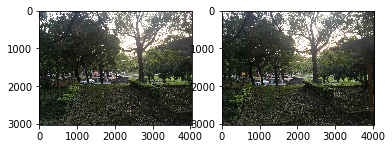

In [2]:
img1 = cv2.imread('./images/img1.jpg')#dist
img2 = cv2.imread('./images/img2.jpg')#src
plt.subplot(121)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()
h,w, _ = img1.shape
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img1_target = img1_gray
img2_target = img2_gray

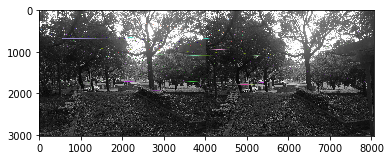

In [3]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1_target, None)
kp2, des2 = orb.detectAndCompute(img2_target, None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
matches = matches[:int(len(matches)*0.1)]

plt.imshow(cv2.cvtColor(cv2.drawMatches(img1_target, kp1, img2_target, kp2, matches, None), cv2.COLOR_BGR2RGB))

In [4]:
src_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
dst_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
# Perspective
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
img_warp = cv2.warpPerspective(img2, M, (w, h))
# Affine
#M = cv2.estimateRigidTransform(src_pts, dst_pts, True)
#img_warp = cv2.warpAffine(img2, M, (w, h))
# Rigid
#M = cv2.estimateRigidTransform(src_pts, dst_pts, False)
#img_warp = cv2.warpAffine(img2, M, (w, h))

In [5]:
frames = [img1, img_warp]
for i in range(len(frames)):
    frames[i] = Image.fromarray(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
    frames[i] = frames[i].crop((w*0.1, h*0.1, w*0.9, h*0.9))#left, upper, right, and lower
    frames[i] = frames[i].resize((int(0.25*w), int(0.25*h)))
frames[0].save('output1.gif', save_all=True, append_images=frames[1:], loop = 0xffff, duration = 250)

![](./output1.gif)

## Stop motion

In [6]:
%matplotlib inline
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

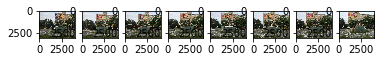

In [7]:
images = []
img_num = 8
for i in range(img_num):
    images.append(cv2.imread('./images/img3_%d.jpg'%(i+1)))
    plt.subplot(1, img_num, i+1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
def align(img1, img2):
    h,w, _ = img1.shape
    img1_target = img1
    img2_target = img2
    #img1_target = foreground(img1)
    #img2_target = foreground(img2)
    img1_target = cv2.cvtColor(img1_target, cv2.COLOR_BGR2GRAY)
    img2_target = cv2.cvtColor(img2_target, cv2.COLOR_BGR2GRAY)

    
    # Initiate ORB detector
    orb = cv2.ORB_create()

    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1_target, None)
    kp2, des2 = orb.detectAndCompute(img2_target, None)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    '''
    # SIFT
    sift = cv2.xfeatures2d.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    '''
    
    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    target_matches = []
    for m in matches:
        x1, y1 = kp1[m.queryIdx].pt
        x2, y2 = kp2[m.trainIdx].pt
        if x1 > w*0.38 and x1 < w*0.62 and y1 > h*0.3 and y1 < h*0.8:
            if x2 > w*0.38 and x2 < w*0.62 and y2 > h*0.3 and y2 < h*0.8:
                target_matches.append(m)
    matches = target_matches
    matches = sorted(matches, key = lambda x:x.distance)
    matches = matches[:6]
    
    fig,ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(cv2.drawMatches(img1_target, kp1, img2_target, kp2, matches, None), cv2.COLOR_BGR2RGB))
    rect1 = patches.Rectangle((w*0.38,h*0.3),w*0.34,h*0.5,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect1)
    rect2 = patches.Rectangle((w+w*0.38,h*0.3),w*0.34,h*0.5,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect2)
    plt.show()
    
    src_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    # Rigid
    M = cv2.estimateRigidTransform(src_pts, dst_pts, False)
    if M is None: return None
    img_warp = cv2.warpAffine(img2, M, (w, h))
    # Perspective
    #M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    #img_warp = cv2.warpPerspective(img2, M, (w, h))
    return img_warp

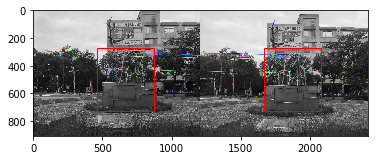

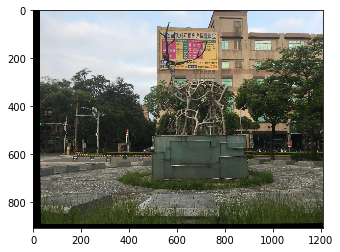

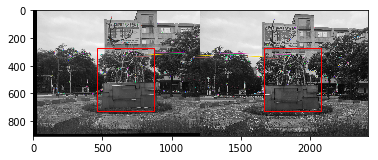

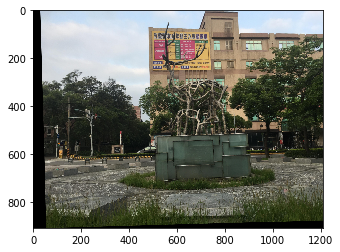

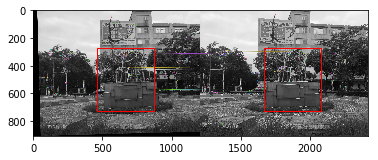

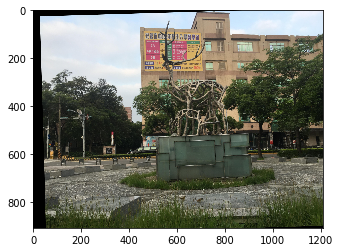

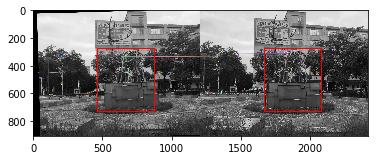

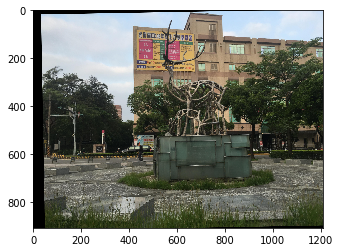

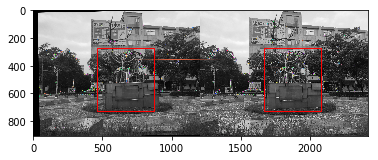

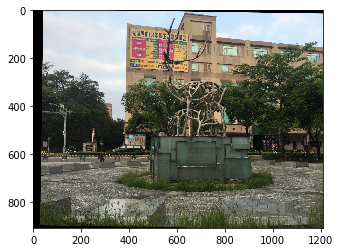

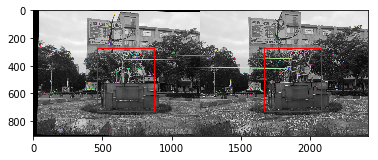

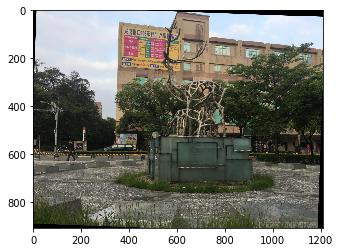

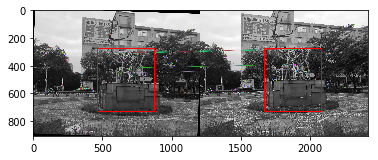

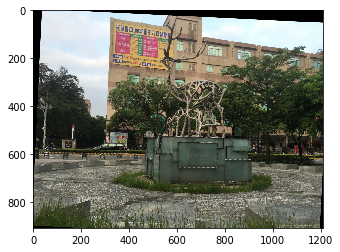

In [9]:
frames = []
n = 0.3
h,w, _ = images[0].shape
last_img = cv2.resize(images[0], (int(w*n), int(h*n)))
h,w, _ = images[0].shape
frames.append(Image.fromarray(cv2.cvtColor(last_img, cv2.COLOR_BGR2RGB)).resize((int(0.25*w), int(0.25*h))))
for i in range(1, img_num):
    img = align(cv2.resize(last_img, (int(w*n), int(h*n))), cv2.resize(images[i], (int(w*n), int(h*n))))
    if img is None: continue
    last_img = img
    frames.append(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).resize((int(0.25*w), int(0.25*h))))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
for i in range(len(frames)):
    w, h= frames[i].size
    frames[i] = frames[i].crop((w*0.1, h*0.1, w*0.9, h*0.9))#left, upper, right, and lower
frames_reverse = frames[:]
frames_reverse.reverse()
frames[0].save('output2.gif', save_all=True, append_images=frames[1:]+frames_reverse[1:-1], loop = 0xffff, duration = 100)

![](./output2.gif)